In [1]:
import pandas as pd
import numpy as np
from os.path import join as opj
from collections import defaultdict, Counter
from sklearn.model_selection import train_test_split
import sys
sys.path.append('/home/isabrah/sustainable_high_quality_wikis')
from sklearn.impute import SimpleImputer
import shap
import matplotlib.pyplot as plt
import json
import matplotlib as mpl
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier

### Configurations and Data Loading

In [2]:
def normalize_feature_name(f_name):
    if f_name == 'EXPERIENCE_unweighted_score':
        return '[Experience] Unweighted-Score'
    elif f_name == 'EDIT_time_to_promotion':
        return  '[Edit-History] Time-to-Promotion'
    elif f_name == 'EXPERIENCE_weighted_score':
        return '[Experience] Weighted-Score'
    elif f_name == 'CREDIBILITY_weighted_score':
        return '[Experience] Credibility-Weighted-Score'
    elif f_name == 'CREDIBILITY_unweighted_score':
        return '[Experience] Credibility-Unweighted-Score'
    elif f_name == 'SPECIAL_used_to_be_good_article':
        return '[Edit-History] Was-a-Good-Article'
    elif f_name == 'EDIT_num_revisions_normalized':
        return '[Edit-History] Num-of-Revisions-Normalized'
    elif f_name == 'DISCUSSIONS_median_authors':
        return '[Discussions] Median-Num-of-Discussers'
    elif f_name == 'NETWORK_closeness_stdev':
        return '[Network] Closeness-Stdev'
    elif f_name == 'TOPIC_4_politics':
        return '[Topics] Politics'
    else:
        return f_name.lower()

In [3]:
base_folder = '/shared/3/projects/relationship-aware-networks-wikipedia'
model_folder = opj(base_folder, 'models')
model_to_import = 10.2
target_column = 'is_sustainable_conservative_approach'#'is_sustained'
test_perc = None # not really needed
save_features_importance_fig = True

In [26]:
cur_model_results_f_name = opj(model_folder, str(model_to_import), 'bootstrap_eval_measures_test.csv')
modeling_df = pd.read_csv(opj(model_folder, str(model_to_import), 'modeling_df.csv'))
minority_class_cnt = min(list(Counter(modeling_df[target_column]).values()))
minority_class_perc = minority_class_cnt / modeling_df.shape[0]

In [27]:
model_params_f_name = opj(model_folder, str(model_to_import), 'model_params.json')
with open(model_params_f_name, 'r', encoding='utf-8') as infile:
    model_info_dict = json.load(infile)
    infile.close()
classification_model = eval(model_info_dict['classification_model'])
seed = model_info_dict['seed']
usecase = model_info_dict['usecase']
max_year_to_include = model_info_dict['max_year_to_include']

# Set the first column as the index
modeling_df.set_index(modeling_df.columns[0], inplace=True)
modeling_df[target_column] = modeling_df[target_column].astype(int)

# filtering too new articles
# if max_year_to_include is not None:
#     modeling_df = modeling_df[modeling_df['TIME_promotion_year'] <= max_year_to_include].copy()
#     print(f"Max year filter has been applied. Filtered dataset shape: {modeling_df.shape}.", flush=True)
# all features that start with 'TIME_' should not be included in the modeling df
x_columns = [c for c in modeling_df.columns if c != target_column and not c.startswith('TIME_')]
x_df = modeling_df[x_columns].copy()
y_col = modeling_df[target_column]

### Model training

In [6]:
if test_perc is None:
    x_train = x_df
    y_train = y_col
    imputer = SimpleImputer(strategy='mean')
    x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
    classification_model.fit(x_train_imputed, y_train)
else:
    x_train, x_test, y_train, y_test = train_test_split(x_df, y_col, stratify=y_col, test_size=test_perc, random_state=seed)
    # filling the missing values with the mean
    imputer = SimpleImputer(strategy='mean')
    # Fit the imputer on the training data and transform both train and test sets
    x_train_imputed = pd.DataFrame(imputer.fit_transform(x_train), columns=x_train.columns)
    x_test_imputed = pd.DataFrame(imputer.transform(x_test), columns=x_train.columns)
    classification_model.fit(x_train_imputed, y_train)

### SHAP analysis and printing

In [9]:
# Initialize SHAP explainer
explainer = shap.Explainer(classification_model, x_train_imputed)
# Calculate SHAP values
shap_values = explainer(x_train_imputed)
shap_df = pd.DataFrame(shap_values.values, columns=x_train_imputed.columns)
shap_df[target_column] = list(y_train)

In [10]:
shap_values_sust_articles = shap_df[shap_df[target_column]==1].copy()
shap_values_unsust_articles = shap_df[shap_df[target_column]==0].copy()

In [11]:
# we can determine the "direction" of each feature by the mean of the positive class per feature
feature_direction = dict()
for column in x_train_imputed.columns:
    cur_shape_mean = np.mean(shap_values_sust_articles[column])
    feature_direction[column] = 1 if cur_shape_mean > 0 else -1
color_mapping = {feature: '#91bfdb' if direction==-1 else '#fc8d59' for feature, direction in feature_direction.items()}
bar_mapping = {feature: '\\' if direction==-1 else '/' for feature, direction in feature_direction.items()}

In [12]:
# Calculate the mean absolute SHAP value for each feature
shap_importance = np.abs(shap_values.values).mean(axis=0)
# Sort features by importance
sorted_idx = np.argsort(shap_importance)[::-1]
sorted_shap_values = shap_importance[sorted_idx]
sorted_features = x_train_imputed.columns[sorted_idx]

# Limit to the top 20 features
top_n = 10
sorted_shap_values = sorted_shap_values[:top_n]
sorted_features = sorted_features[:top_n]

# Prepare colors for the bars
bar_colors = [color_mapping[feature] for feature in sorted_features]
bar_patterns = [bar_mapping[feature] for feature in sorted_features]
sorted_features_name_normalized = [normalize_feature_name(sf) for sf in sorted_features[:top_n]]

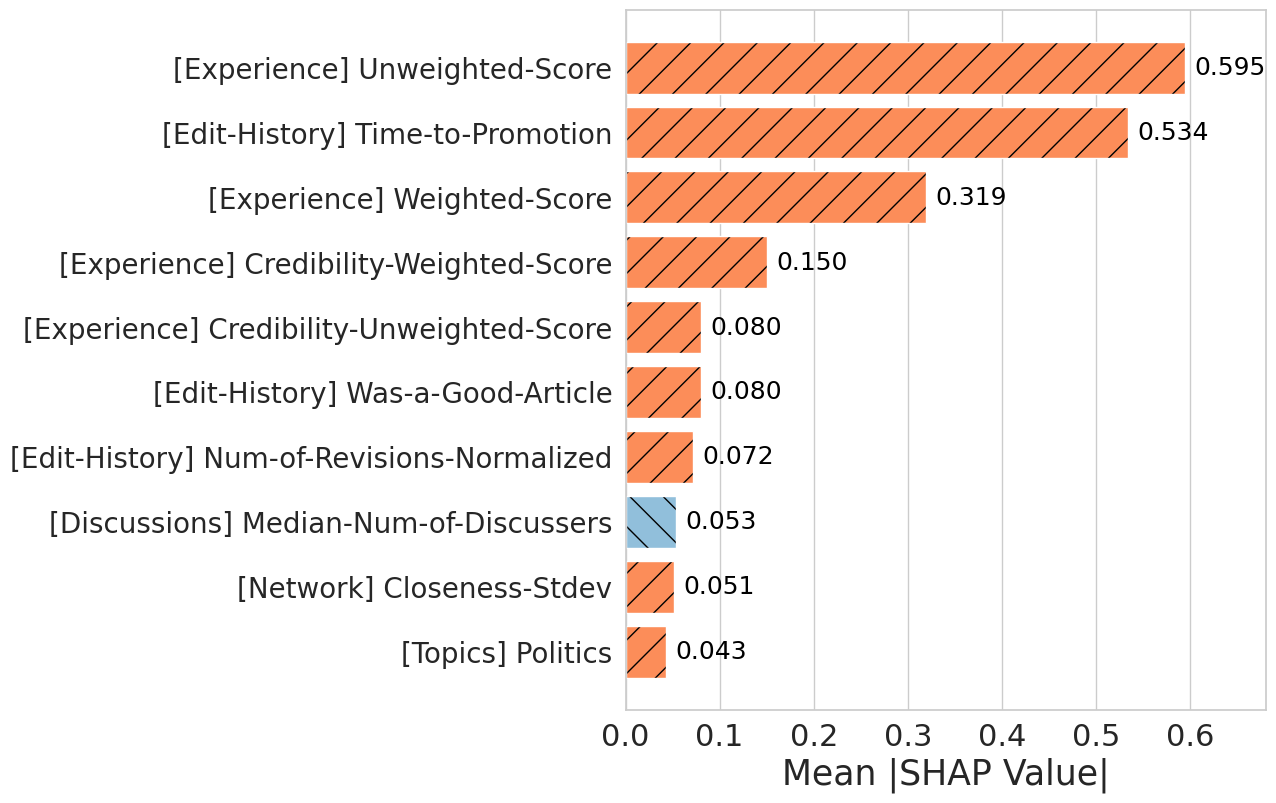

In [25]:
sns.set(style='whitegrid')
plt.figure(figsize=(8, 5))
# Plot the SHAP values using matplotlib with custom colors
bar_height = 0.8
bars = plt.barh(sorted_features_name_normalized[::-1], sorted_shap_values[::-1], color=bar_colors[::-1], hatch=bar_patterns[::-1], height=bar_height)

# setting the colors of the hatches (patterns) to black
for bc in bars:
    bc._hatch_color = mpl.colors.to_rgba("black")
    bc.stale = True
    
# Add SHAP value labels next to each bar
for bar in bars:
    plt.text(
        bar.get_width() + 0.01,  # Position right next to the bar
        bar.get_y() + bar.get_height() / 2,  # Center the text vertically on the bar
        f'{bar.get_width():.3f}',  # Format the text with 4 decimal places
        va='center',  # Vertical alignment
        fontsize=18,  # Font size
        color='black'  # Font color
    )

# Adjust spacing between the bars and the top of the plot
plt.subplots_adjust(left=0.2, right=1.0, top=1.5, bottom=0.1)

plt.xlabel('Mean |SHAP Value|', fontsize=25)
plt.xticks(fontsize=22)
plt.yticks(fontsize=20)
plt.xlim(right=0.68)

plt.grid(axis='y', visible=False)  # Turn off the y-axis grid
# saving option
saving_file_name = 'SHAP_feature_importance.pdf'
if save_features_importance_fig:
    plt.savefig(opj(base_folder, 'models', 'models_analysis', str(model_to_import), saving_file_name), format="pdf", bbox_inches="tight", dpi=1200)
plt.show()

### LEFTOVERS - summary plot of shap which is not used for the paper

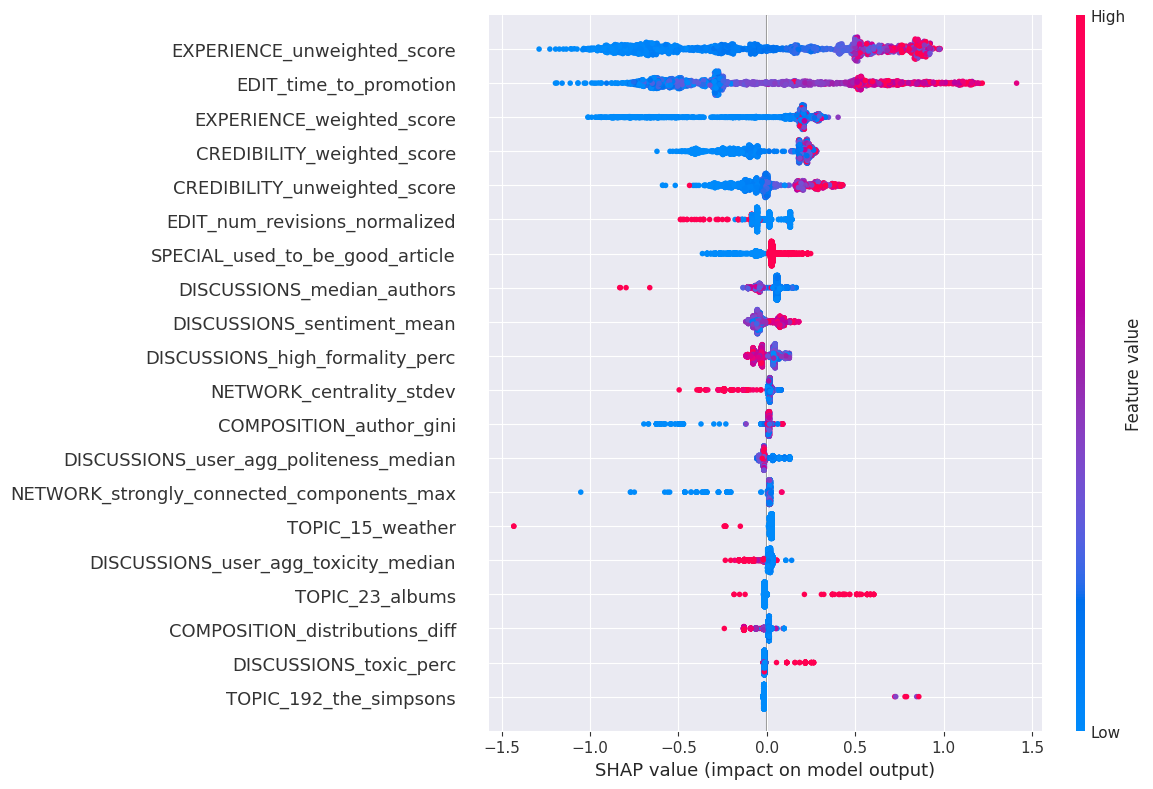

In [9]:
# Plotting option B - summary plot
# Plot the SHAP summary plot
shap.summary_plot(shap_values, x_test_imputed, feature_names=x_test_imputed.columns, plot_size=(12, 8))